### install pacakages

In [2]:
%pip install pandas
%pip install matplotlib
%pip install scikit-learn

  Using cached pandas-2.0.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.4 MB)
     |████████████████████████████████| 505 kB 16.0 MB/s eta 0:00:01
  Using cached numpy-1.24.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
     |████████████████████████████████| 345 kB 15.8 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.
     |████████████████████████████████| 9.2 MB 18.7 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 122.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 118.6 MB/s eta 0:00:01
     |████████████████████████████████| 4.7 MB 103.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.
     |████████████████████████████████| 11.1 MB 20.3 MB/s eta 0:00:01
     |████████████████████████████████| 301 kB 139.4 MB/s eta 0:00:01
  Using cached scipy-1.10.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.5 MB)
Note: you may need to rest

### 학습 및 테스트 데이터 셋 로드 (예제에서는 MNIST 글자 데이터 셋 사용)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(2021) #실행할 때마다 동일한 난수 시퀀스가 생성

from sklearn.datasets import load_digits #sklearn.datasets 모듈에서 load_digits() 함수를 사용하여 손글씨 숫자 데이터셋을 불러온다.

digits = load_digits() #데이터셋에서 data와 target을 추출
#. data는 8x8 픽셀 이미지로 표현된 숫자 이미지 데이터이며, target은 해당 이미지가 나타내는 숫자 레이블을 뜻함

data, target = digits["data"], digits["target"] #data와 target 변수에 각각 이미지 데이터와 레이블을 저장

### 간단한 데이터 테스트

In [4]:
data[0].shape # (8, 8) -> (64, 0)

(64,)

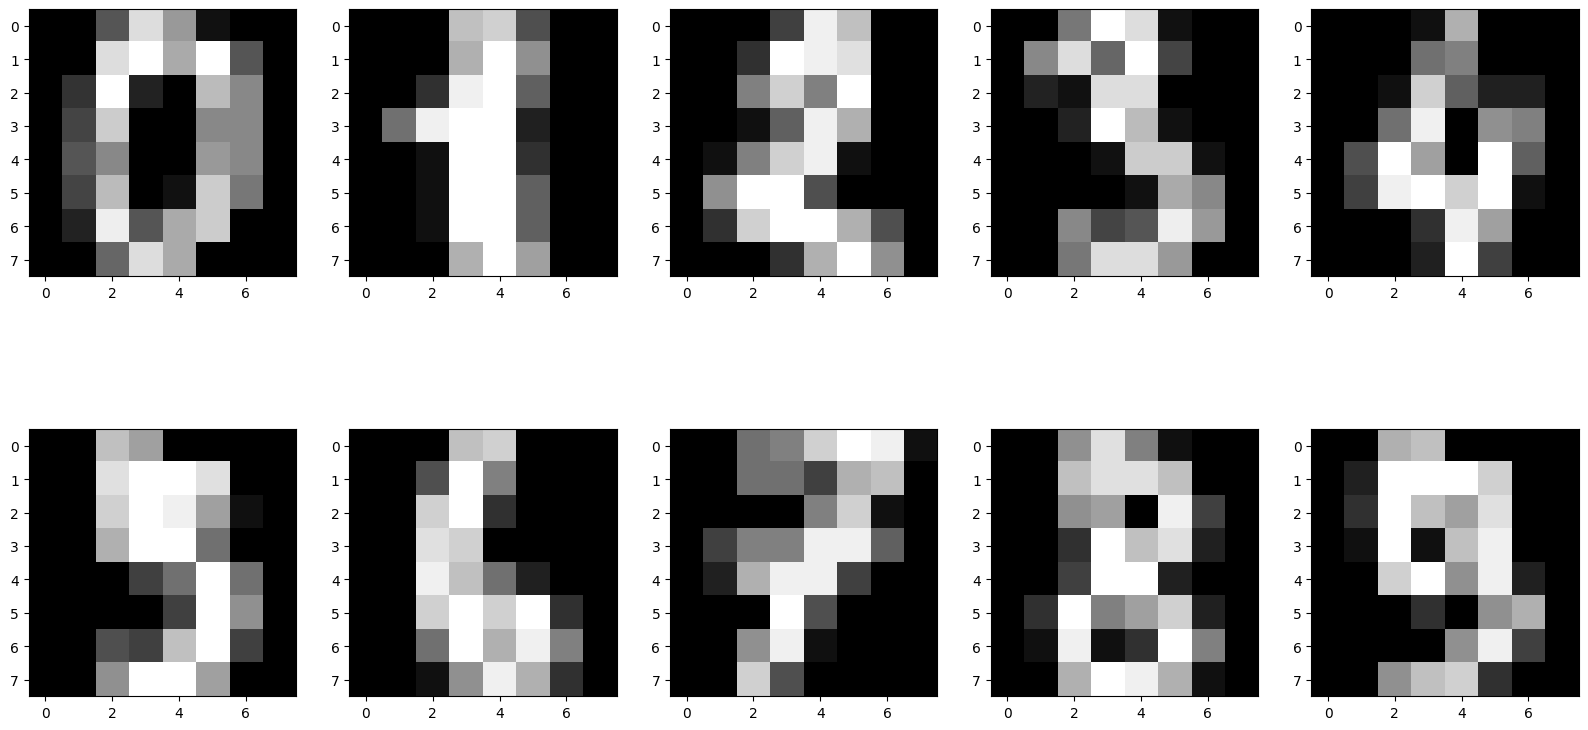

In [5]:
samples = data[:10].reshape(10, 8, 8) # 데이터 시각화
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
for idx, sample in enumerate(samples):
    axes[idx//5, idx%5].imshow(sample, cmap="gray")

### 데이터셋 분리 (7:3)

In [6]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_target, test_target = train_test_split(
    data, target, train_size=0.7, random_state=2021
)

### 모델 학습 

In [7]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()

random_forest.fit(train_data, train_target) #학습

RandomForestClassifier()

### FEATURE IMPORTANCE 추출

In [8]:
random_forest.feature_importances_ #Feature Importance
feature_importance = pd.Series(random_forest.feature_importances_)

feature_importance = feature_importance.sort_values(ascending=False)
feature_importance.head(10)

21    0.046149
26    0.042105
42    0.039239
36    0.039174
43    0.036726
20    0.032388
30    0.032027
28    0.030734
33    0.030467
61    0.029491
dtype: float64

### FEATURE IMPORTANCE 시각화
실제 글자 구분에 중요한 부분을 표기

(-0.5, 7.5, 7.5, -0.5)

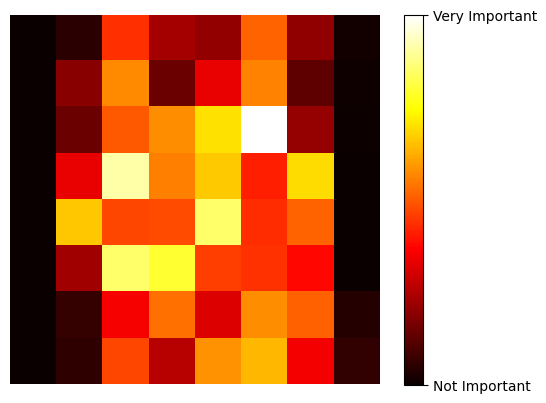

In [9]:
image = random_forest.feature_importances_.reshape(8, 8)
plt.imshow(image, cmap=plt.cm.hot, interpolation="nearest")
cbar = plt.colorbar(ticks=[random_forest.feature_importances_.min(), random_forest.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not Important', 'Very Important'])
plt.axis("off")

### 평가 

In [11]:
from sklearn.metrics import accuracy_score

train_pred = random_forest.predict(train_data)
test_pred = random_forest.predict(test_data)

train_acc = accuracy_score(train_target, train_pred)
test_acc = accuracy_score(test_target, test_pred)

print(f"train accuracy is {train_acc:.4f}")
print(f"test accuracy is {test_acc:.4f}")

train accuracy is 1.0000
test accuracy is 0.9667


### 하이퍼 파라미터 조정 해보기
* n_estimators :
  몇 개의 나무를 생성할 것 인지 정합니다.
* criterion :
  어떤 정보 이득을 기준으로 데이터를 나눌지 정합니다.
  "gini", "entropy"
* max_depth :
  나무의 최대 깊이를 정합니다.
* min_samples_split :
  노드가 나눠질 수 있는 최소 데이터 개수를 정합니다.  


  **일일이 하이퍼 파라미터 조정하는 것은 생각보다 어려움! => GridSearchCV 를 이용해서 자동으로 조정(단, 시간과 비용이 발생)**

In [12]:
# 랜덤 포레스트 모델을 사용하여 Grid Search를 수행하는 코드
from sklearn.model_selection import GridSearchCV
params = {
    "n_estimators": [i for i in range(100, 1000, 200)],
    "max_depth": [i for i in range(10, 50, 10)],
} #탐색할 값들의 argument와 범위를 정한다.
random_forest = RandomForestClassifier() #탐색에 사용할 모델을 생성

#탐색 시작 (cv는 k-fold의 k값을 말한다)
grid = GridSearchCV(estimator=random_forest, param_grid=params, cv=3)
grid = grid.fit(train_data, train_target)

#결과
print(f"Best score of paramter search is: {grid.best_score_:.4f}") #{'max_depth': 30, 'n_estimators': 300} 출력

print("Best parameter of best score is")
print(f"\t max_depth: {grid.best_params_['max_depth']}")
print(f"\t n_estimators: {grid.best_params_['n_estimators']}")

Best score of paramter search is: 0.9730
Best parameter of best score is
	 max_depth: 30
	 n_estimators: 300
